In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [3]:
import pandas as pd

df = pd.read_csv('./data/AAC 과거 데이터.csv')['종가']#, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
df

0      10.69
1      10.70
2      10.69
3      10.69
4      10.69
       ...  
162    10.13
163    10.11
164    10.11
165    10.10
166    10.11
Name: 종가, Length: 167, dtype: float64

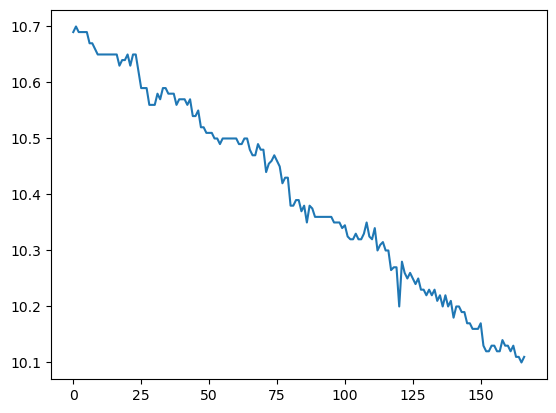

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('./data/AAC 과거 데이터.csv')[['종가']].values.astype('float32')
 
plt.plot(df)
plt.show()

In [43]:
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]

In [44]:

import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [45]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([110, 1, 1]) torch.Size([110, 1, 1])
torch.Size([55, 1, 1]) torch.Size([55, 1, 1])


In [59]:

import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [60]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 10.1106, test RMSE 9.8110
Epoch 100: train RMSE 0.0882, test RMSE 0.2363
Epoch 200: train RMSE 0.0877, test RMSE 0.2361
Epoch 300: train RMSE 0.0865, test RMSE 0.2285
Epoch 400: train RMSE 0.0834, test RMSE 0.2252
Epoch 500: train RMSE 0.0766, test RMSE 0.1956
Epoch 600: train RMSE 0.0614, test RMSE 0.1516
Epoch 700: train RMSE 0.0435, test RMSE 0.1159
Epoch 800: train RMSE 0.0334, test RMSE 0.0514
Epoch 900: train RMSE 0.0193, test RMSE 0.0387
Epoch 1000: train RMSE 0.0190, test RMSE 0.0201
Epoch 1100: train RMSE 0.0267, test RMSE 0.0257
Epoch 1200: train RMSE 0.0278, test RMSE 0.0339
Epoch 1300: train RMSE 0.0152, test RMSE 0.0212
Epoch 1400: train RMSE 0.0135, test RMSE 0.0205
Epoch 1500: train RMSE 0.0186, test RMSE 0.0249
Epoch 1600: train RMSE 0.0220, test RMSE 0.0262
Epoch 1700: train RMSE 0.0230, test RMSE 0.0274
Epoch 1800: train RMSE 0.0159, test RMSE 0.0220
Epoch 1900: train RMSE 0.0150, test RMSE 0.0219


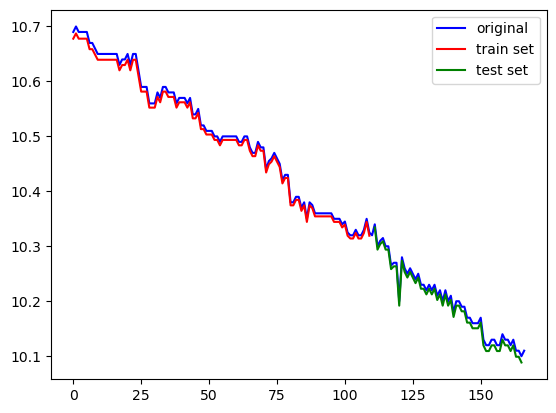

In [67]:

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)[:, -1, :]
# plot
plt.plot(df, c='b', label='original')
plt.plot(train_plot[1:], c='r', label='train set')
plt.plot(test_plot[1:], c='g', label='test set')
plt.legend()
plt.show()

In [5]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('./data/AAC 과거 데이터.csv')['종가']#, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
df = df[::-1]  
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

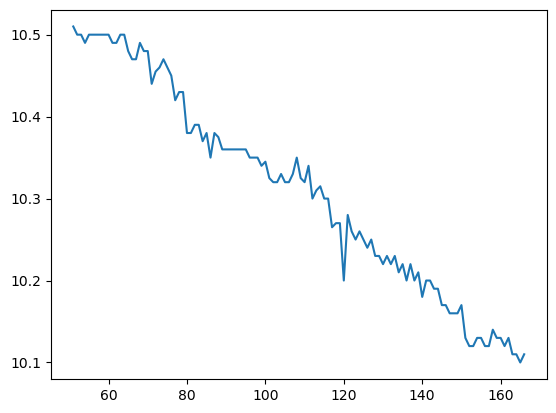

In [6]:
plt.plot(train_set)

In [7]:
# Input scale
import numpy as np
scaler_x = MinMaxScaler()
train_set = np.array(train_set).reshape(-1, 1)
test_set = np.array(test_set).reshape(-1, 1)
scaler_x.fit(train_set)

train_set = scaler_x.transform(train_set)
test_set = scaler_x.transform(test_set)

# # Output scale
# scaler_y = MinMaxScaler()
# scaler_y.fit(train_set)

# train_set = scaler_y.transform(train_set)
# test_set = scaler_y.transform(test_set)

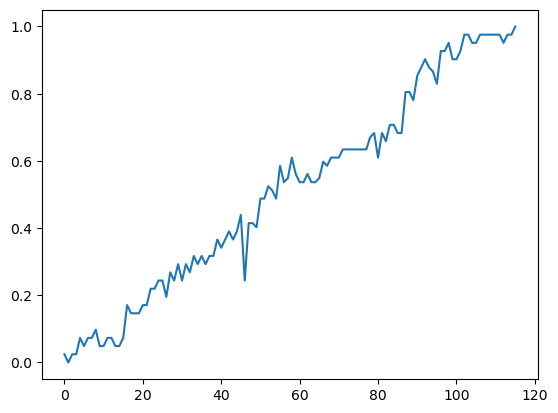

In [8]:
plt.plot(train_set)

In [9]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [10]:
# 설정값
data_dim = 1
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 100

class Model(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [11]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [12]:
# 모델 학습
model = Model(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(model, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.6616
Epoch: 0020 train loss : 0.0443
Epoch: 0040 train loss : 0.0299
Epoch: 0060 train loss : 0.0025

 Early Stopping


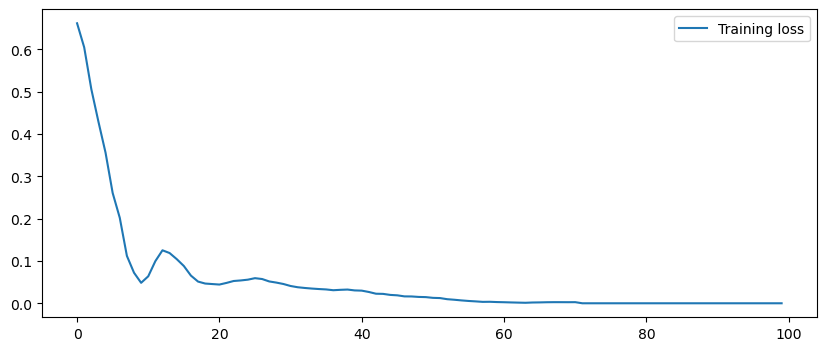

In [13]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_x.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_x.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  0.02638654835083884


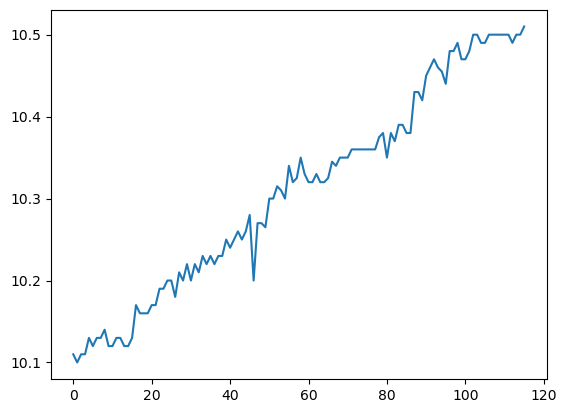

In [23]:
plt.plot(scaler_x.inverse_transform(train_set))

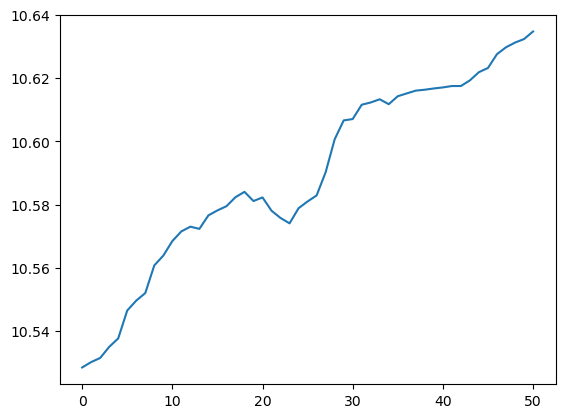

In [21]:
plt.plot(pred_inverse)

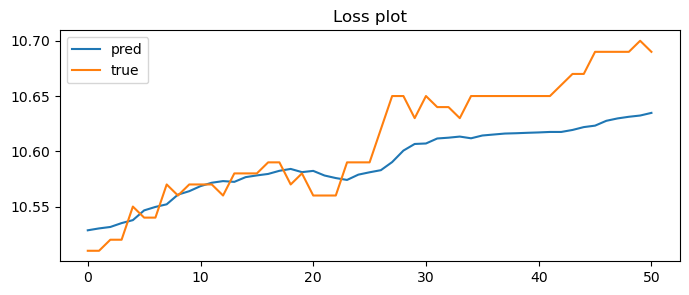

In [16]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()

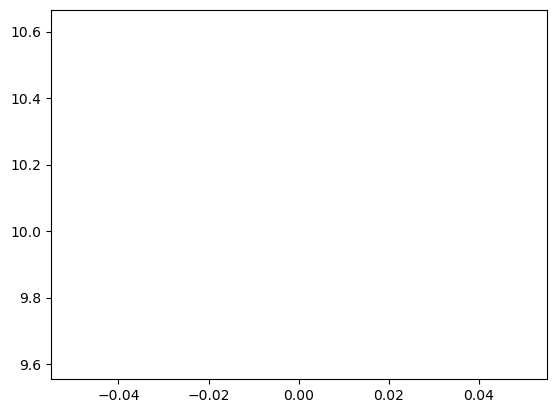

In [17]:
plt.plot(df.iloc[0])

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df)
normalized = scaler.transform(df)
plt.plot(normalized[0])

ValueError: Expected 2D array, got 1D array instead:
array=[10.11  10.1   10.11  10.11  10.13  10.12  10.13  10.13  10.14  10.12
 10.12  10.13  10.13  10.12  10.12  10.13  10.17  10.16  10.16  10.16
 10.17  10.17  10.19  10.19  10.2   10.2   10.18  10.21  10.2   10.22
 10.2   10.22  10.21  10.23  10.22  10.23  10.22  10.23  10.23  10.25
 10.24  10.25  10.26  10.25  10.26  10.28  10.2   10.27  10.27  10.265
 10.3   10.3   10.315 10.31  10.3   10.34  10.32  10.325 10.35  10.33
 10.32  10.32  10.33  10.32  10.32  10.325 10.345 10.34  10.35  10.35
 10.35  10.36  10.36  10.36  10.36  10.36  10.36  10.36  10.375 10.38
 10.35  10.38  10.37  10.39  10.39  10.38  10.38  10.43  10.43  10.42
 10.45  10.46  10.47  10.46  10.455 10.44  10.48  10.48  10.49  10.47
 10.47  10.48  10.5   10.5   10.49  10.49  10.5   10.5   10.5   10.5
 10.5   10.5   10.49  10.5   10.5   10.51  10.51  10.51  10.52  10.52
 10.55  10.54  10.54  10.57  10.56  10.57  10.57  10.57  10.56  10.58
 10.58  10.58  10.59  10.59  10.57  10.58  10.56  10.56  10.56  10.59
 10.59  10.59  10.62  10.65  10.65  10.63  10.65  10.64  10.64  10.63
 10.65  10.65  10.65  10.65  10.65  10.65  10.65  10.65  10.66  10.67
 10.67  10.69  10.69  10.69  10.69  10.7   10.69 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
reshaped_data = data.view([data.shape[0], data.shape[1], -1])
print(f"Shape of reshaped data : {reshaped_data.shape}")

NameError: name 'data' is not defined

In [ ]:
x_data = reshaped_data[:-1]
y_data = reshaped_data[1:]

In [ ]:
test_x, test_y = x_data[-1:], y_data[-1:]
train_data_x, train_data_y = x_data[:-1], y_data[:-1]

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_data_x, train_data_y, train_size=0.7, shuffle=False, stratify=None)

In [ ]:
train_dataset = TensorDataset(train_x, train_y)
train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=50,
                        shuffle=True,
                        drop_last=True)

valid_dataset = TensorDataset(valid_x, valid_y)
valid_dataloader = DataLoader(dataset=valid_dataset,
                        batch_size=50,
                        shuffle=True,
                        drop_last=True)

In [ ]:
class PyTorch_Model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=False):
        
        super(PyTorch_Model,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=False)
        self.fc1 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.drop1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.drop2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x):
        # Reshape Input Size for batch_first=True
        x = x.transpose(0, 1) # (B, L, I) -> (L, B, I)
    
        x, _status = self.rnn(x) # output x : (L, B, H)
        x = self.fc1(x) # (L, B, H) -> (L, B, H)
        x = self.drop1(x)
        x = self.fc2(x) # (L, B, H) -> (L, B, H)
        x = self.drop2(x)
        x = self.fc3(x) # (L, B, H) -> (L, B, O)
        
        # Reshape Output Size for batch_first=True
        x = x.transpose(0, 1) # (L, B, O) -> (B, L, O)
        return x

In [ ]:
def train(model, optimizer, model_name="RNN_Model", verbose=True):
    print('Learning started. It takes sometime.')
    total_train_batch = len(train_x)
    total_valid_batch = len(valid_x)
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        # Model training
        model.train()
        train_avg_cost = 0
        for idx, samples in enumerate(train_dataloader):
            x, y = samples
            hypothesis = model(x)
            cost = criterion(hypothesis, y)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            train_avg_cost += cost / total_train_batch
        train_loss.append(train_avg_cost)
            
        # Model validation
        model.eval()
        with torch.no_grad():
            valid_avg_cost = 0
            for idx, samples in enumerate(valid_dataloader):
                x, y = samples
                hypothesis = model(x)
                cost = criterion(hypothesis, y)

                valid_avg_cost += cost / total_valid_batch
            valid_loss.append(valid_avg_cost)
            
        if verbose:
            print('[Epoch:{:>2}] train_cost={:<21}, valid_cost={:<21}'.format(epoch + 1, train_avg_cost, valid_avg_cost))
                  
    print('Training Finished.')
    
    train_loss = [l.detach().cpu() for l in train_loss]
    valid_loss = [l.cpu() for l in valid_loss]
    return train_loss, valid_loss

In [ ]:
epochs = 100
learning_rate = 1e-3

input_size = 1
hidden_size = 128
output_size = 1
seq_len = 24
num_layers = 4

In [ ]:
# Instantiate RNN model
given_model = PyTorch_Model(input_size, hidden_size, output_size, num_layers, batch_first=True).to(device)
print(given_model)

# Set loss and optimizer function
criterion = nn.L1Loss().to(device)
given_optimizer = optim.Adam(given_model.parameters(), lr=learning_rate)

PyTorch_Model(
  (rnn): RNN(1, 128, num_layers=4)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
given_train_loss, given_valid_loss = train(given_model, given_optimizer, model_name="PyTorch_Model")

Learning started. It takes sometime.
[Epoch: 1] train_cost=0.0037134485319256783, valid_cost=0.0030142655596137047
[Epoch: 2] train_cost=0.002623087028041482 , valid_cost=0.002134565496817231 
[Epoch: 3] train_cost=0.0022509745322167873, valid_cost=0.0019562116358429193
[Epoch: 4] train_cost=0.0020988949108868837, valid_cost=0.0018050812650471926
[Epoch: 5] train_cost=0.0019099728669971228, valid_cost=0.0016573817702010274
[Epoch: 6] train_cost=0.0018406971357762814, valid_cost=0.0015912455273792148
[Epoch: 7] train_cost=0.0018265503458678722, valid_cost=0.0016259709373116493
[Epoch: 8] train_cost=0.0018749882001429796, valid_cost=0.0018347209552302957
[Epoch: 9] train_cost=0.0019212138140574098, valid_cost=0.0017891500610858202
[Epoch:10] train_cost=0.0018740688683465123, valid_cost=0.0017266013892367482
[Epoch:11] train_cost=0.001877090078778565 , valid_cost=0.0016339202411472797
[Epoch:12] train_cost=0.0018568140221759677, valid_cost=0.0015763412229716778
[Epoch:13] train_cost=0.001

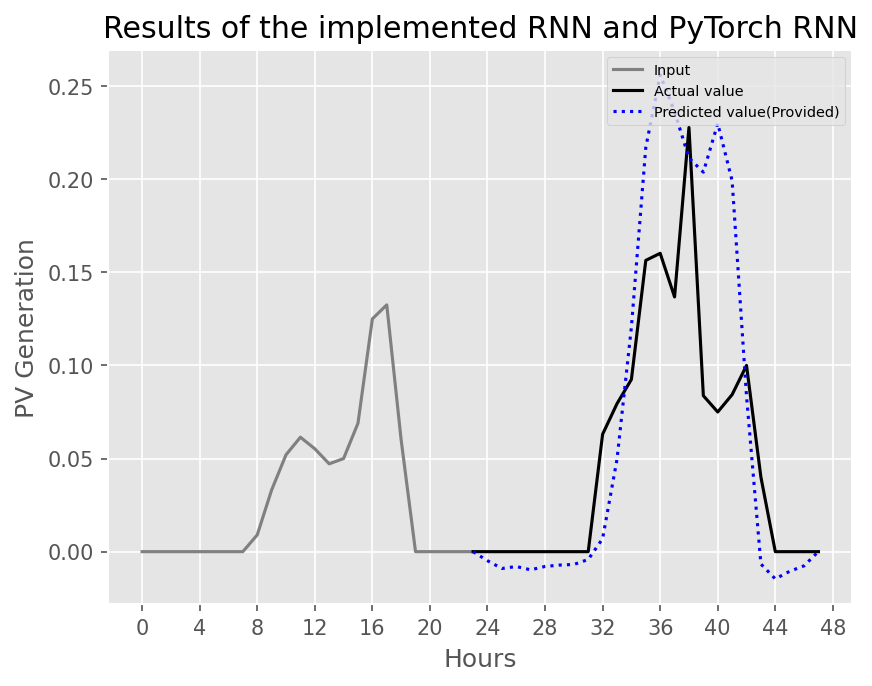

In [ ]:
plt.style.use('ggplot')
plt.figure(dpi=150)
# 축 간격 설정
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))


# 입력 데이터 그래프 그리기 (Input)
input_y = test_x[0].cpu()
input_x = [i for i in range(len(input_y))]
plt.plot(input_x, input_y, color='gray', label='Input')

# 정답 데이터 그래프 그리기 (Actual value)
future = 24
answer_y = test_y[0].cpu()
answer_y = torch.cat([input_y[-1].view(-1, 1), answer_y], dim=0) # 직전 시간의 데이터와 연결해줌
answer_x = [future + i -1 for i in range(len(answer_y))]
plt.plot(answer_x, answer_y, color='black', label='Actual value')


# PyTorch_RNN 모델의 예측 그래프 그리기 (Predicted value(Implemented))
given_output_y = given_model(test_x[0].view([1, -1])).squeeze(0).to('cpu').detach()
given_output_y = torch.cat([input_y[-1], given_output_y], dim=0) # 직전 시간의 데이터와 연결해줌
given_output_x = [future + i -1 for i in range(len(given_output_y))]
plt.plot(given_output_x, given_output_y, color='blue', ls=":", label="Predicted value(Provided)")

plt.xlabel('Hours')
plt.ylabel('PV Generation')
plt.title("Results of the implemented RNN and PyTorch RNN")
plt.legend(fontsize="x-small", loc="upper right")
plt.show()